# Analysis Notebook for Template Technology

In [1]:
import os
import sys

import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb

sys.path.insert(0, os.path.abspath("../../../src"))

import tyche             as ty

## Load data and compile technology models

Every decision context analysis in Tyche will begin with three commands: instantiate the `Designs` class, instantiate the `Investments` class, and compile the technology model functions and data in the `Designs` class. These commands read in and validate the necessary datasets, locate and verify the technology models, and prepare the technology models and data for use in further analyses.

Every decision context has a single Excel workbook containing seven datasets, one per sheet. In no particular order, these datasets are *indices*, *functions*, *designs*, *parameters*, *results*, *tranches*, and *investments*. When the `Designs` and `Investments` classes are instantiated in the code block immediately below, these datasets are automatically checked for internal consistency and completeness. If any of the datasets contain errors or are missing information, the code block below will fail with error messages detailing what data needs to be corrected and in which datasets.

After instantiating the `Designs` class, the `compile` method further processes the numerical datasets to identify any probability distributions in the data and ready them for use in ensemble simulations.

In [2]:
designs = ty.Designs(path = '.',
                     name = 'template.xlsx')

investments = ty.Investments(path = '.',
                             name = 'template.xlsx')

designs.compile()

## Evaluate Funding Tranches

The `evaluate_tranches` method in the code block below performs ensemble simulation (Monte Carlo) with the number of simulations defined with the `sample_count` parameter. For every simulation, values are sampled from all probability distributions present in the input datasets and are used to calculate corresponding Metric values as well as the built-in Cost. Results of these simulations are returned as shown in the second code block below.

In [3]:
tranche_results = investments.evaluate_tranches(designs, sample_count=100).metrics

Evaluating Technology A
Evaluating Technology M


In [4]:
tranche_results.xs(1, level="Sample", drop_level=False)

Value  \
Category                 Tranche                    Scenario                   Sample Technology   Index                                   
Research on Component B0 Component B0 High Funding  Component B0 High Funding  1      Technology A Delta Environment            0.004191   
                                                                                                   Delta Labor                  0.015020   
                                                                                                   Delta Overall Efficiency    -0.003374   
                                                                                                   Delta System Cost          -86.337211   
                                                                                      Technology M Delta Environment            0.036400   
...                                                                                                                                  ...   
Research on Peripherals  Peripherals Medium Funding Peripherals Medium Funding 1      Technology A Delta System Cost        -4333.926205   
                                                                                      Technology M Delta Environment           -1.268492   
                                                                                                   Delta Labor                 -0.117425   
                                                                                                   Delta Overall Efficiency     0.027388   
                                                                                                   Delta System Cost        -5505.396154   

                                                                                                                                                    Units  
Category                 Tranche                    Scenario                   Sample Technology   Index                                                   
Research on Component B0 Component B0 High Funding  Component B0 High Funding  1      Technology A Delta Environment                    delta unit/system  
                                                                                                   Delta Labor                           delta USD/system  
                                                                                                   Delta Overall Efficiency                      unitless  
                                                                                                   Delta System Cost         delta USD/system, annualized  
                                                                                      Technology M Delta Environment                    delta unit/system  
...                                                                                                                                                   ...  
Research on Peripherals  Peripherals Medium Funding Peripherals Medium Funding 1      Technology A Delta System Cost         delta USD/system, annualized  
                                                                                      Technology M Delta Environment                    delta unit/system  
                                                                                                   Delta Labor                           delta USD/system  
                                                                                                   Delta Overall Efficiency                      unitless  
                                                                                                   Delta System Cost         delta USD/system, annualized  

[224 rows x 2 columns]

Ensemble simulation results can be further filtered down to show only aggregate results for a single Scenario. This is done in the code block below, in which the complete set of results is filtered down to only the Current State scenario and then average (mean) values are calculated for every Index.

In [5]:
tranche_results.xs(
    'Current State',
    level='Scenario',
    drop_level=False
).groupby(
    ['Technology', 'Index']
).mean(
    numeric_only=True
)

Value
Technology   Index                              
Technology A Delta Environment          0.004191
             Delta Labor               -0.001086
             Delta Overall Efficiency  -0.003374
             Delta System Cost        -85.816239
Technology M Delta Environment          0.036400
             Delta Labor                0.016639
             Delta Overall Efficiency   0.002722
             Delta System Cost        -54.477587

Here we demonstrate use of the Seaborn visualization package to compare the metric outcomes of each Scenario. Each of the four plots below shows a different metric, quantified as the difference between the Scenario's metric values (one value per simulation) and the average Current State metric value. The plots are put in order of increasing complexity of information presented.

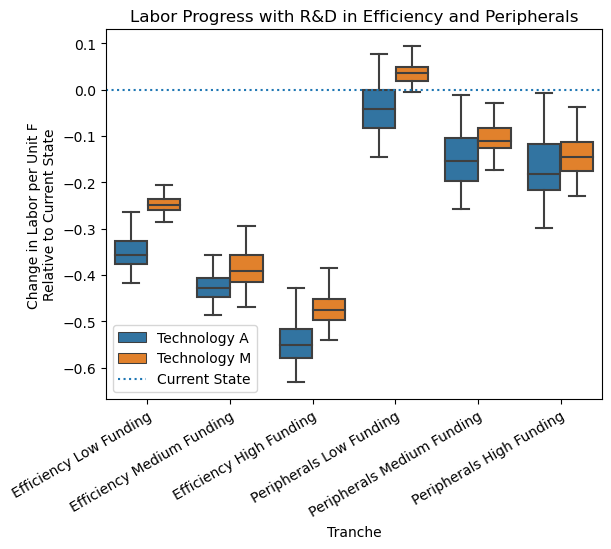

In [6]:
g = sb.boxplot(
    x="Tranche",
    y="Value",
    hue="Technology",
    data=tranche_results.xs(
        "Delta Labor",
        level="Index"
    ).reset_index(
    )[["Technology", "Category", "Tranche", "Value"]],
    order=[
        "Efficiency Low Funding"    ,
        "Efficiency Medium Funding",
        "Efficiency High Funding"    ,
        "Peripherals Low Funding"         ,
        "Peripherals Medium Funding"     ,
        "Peripherals High Funding"         ,
    ]
)
g.set(ylabel="Change in Labor per Unit F\nRelative to Current State",
      title="Labor Progress with R&D in Efficiency and Peripherals")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

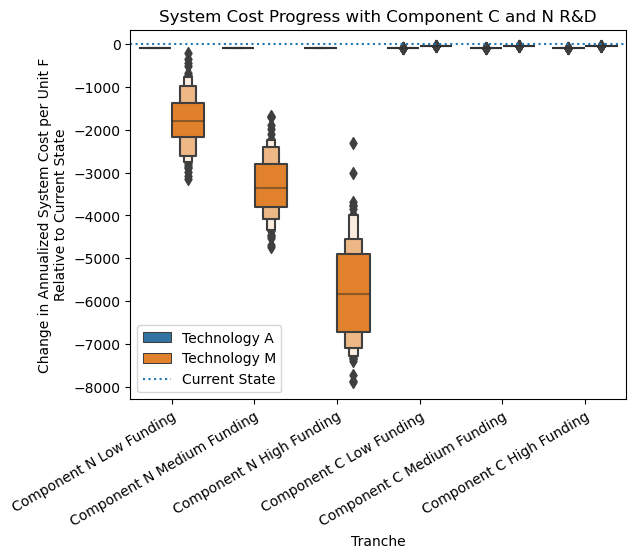

In [7]:
g = sb.boxenplot(
    x="Tranche",
    y="Value",
    hue="Technology",
    data=tranche_results.xs(
        "Delta System Cost",
        level="Index"
    ).reset_index(
    )[["Technology", "Category", "Tranche", "Value"]],
    order=[
        "Component N Low Funding",
        "Component N Medium Funding",
        "Component N High Funding",
        "Component C Low Funding",
        "Component C Medium Funding",
        "Component C High Funding",
    ]
)
g.set(ylabel="Change in Annualized System Cost per Unit F\nRelative to Current State",
     title="System Cost Progress with Component C and N R&D")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

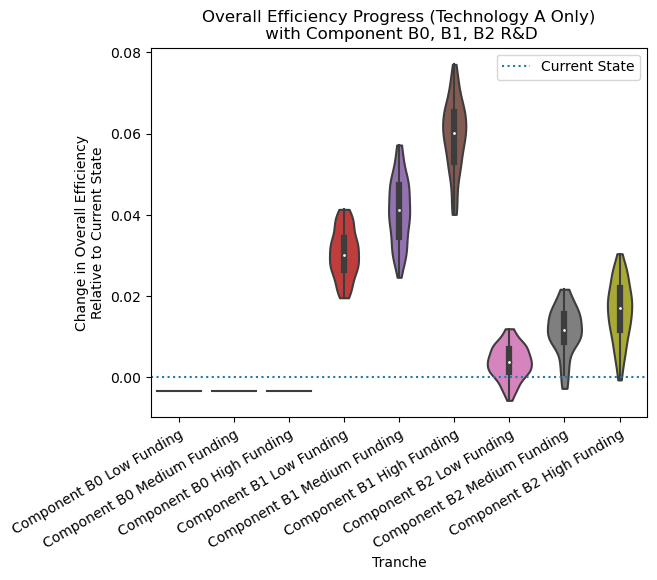

In [8]:
g = sb.violinplot(
    x="Tranche",
    y="Value",
    dodge=True,
    cut=0,
    data=tranche_results.xs(
        ("Delta Overall Efficiency", "Technology A"),
        level=["Index", "Technology"]
    ).reset_index(
    )[["Tranche", "Value"]],
    order=[
        'Component B0 Low Funding',
        'Component B0 Medium Funding',
        'Component B0 High Funding',
        'Component B1 Low Funding',
        'Component B1 Medium Funding',
        'Component B1 High Funding',
        'Component B2 Low Funding',
        'Component B2 Medium Funding',
        'Component B2 High Funding',
    ]
)
g.set(ylabel="Change in Overall Efficiency\nRelative to Current State",
     title="Overall Efficiency Progress (Technology A Only)\n with Component B0, B1, B2 R&D")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

C:\Users\rhanes\AppData\Local\Temp\1\ipykernel_20028\2752349064.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')


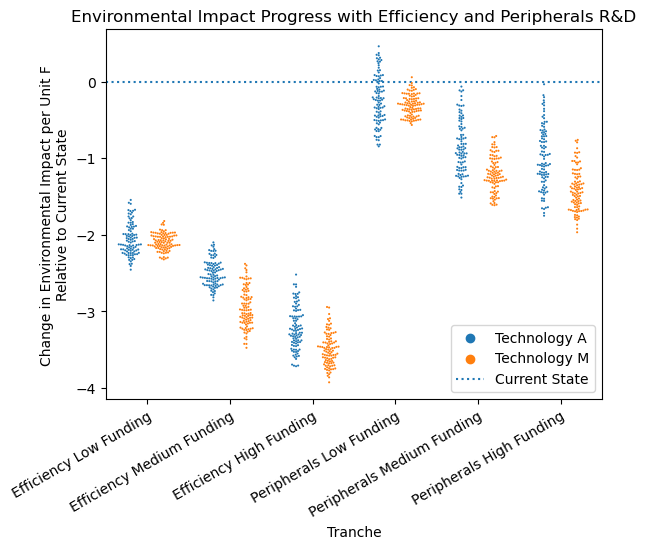

In [9]:
g = sb.swarmplot(
    x="Tranche",
    y="Value",
    hue="Technology",
    data=tranche_results.xs(
        "Delta Environment",
        level="Index"
    ).reset_index()[["Technology", "Category", "Tranche", "Value"]],
    dodge=True,
    size=1.5,
    order=[
        "Efficiency Low Funding"    ,
        "Efficiency Medium Funding",
        "Efficiency High Funding"    ,
        "Peripherals Low Funding"         ,
        "Peripherals Medium Funding"     ,
        "Peripherals High Funding"         ,
    ]
)
g.set(ylabel="Change in Environmental Impact per Unit F\nRelative to Current State",
     title="Environmental Impact Progress with Efficiency and Peripherals R&D")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

## Evaluate the Investments

Each Investment is a combination of one or more Tranches, and as such represent the progress possible when invesments are made across multiple research Categories.

In [10]:
investment_results = investments.evaluate_investments(designs, sample_count=100)

Evaluating Technology A
Evaluating Technology M
Evaluating Technology A
Evaluating Technology M


### Costs of investments

In [11]:
investment_results.amounts

,Amount
Investment,
"High Budget, All Categories",20250000.0
"High Budget, Components Only",15500000.0
"Low Budget, All Categories",9250000.0
"Low Budget, Components Only",6500000.0
"Medium Budget, All Categories",12250000.0
"Medium Budget, Components Only",8500000.0
No Investment,0.0


In [12]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value  \
Investment                     Technology   Sample Index                                    
High Budget, All Categories    Technology A 1      Delta Environment            -6.952548   
                                                   Delta Labor                  -0.784706   
                                                   Delta Overall Efficiency      0.120735   
                                                   Delta System Cost        -32027.962869   
                               Technology M 1      Delta Environment            -6.259131   
                                                   Delta Labor                  -0.765509   
                                                   Delta Overall Efficiency      0.151393   
                                                   Delta System Cost        -27591.191563   
High Budget, Components Only   Technology A 1      Delta Environment            -2.848909   
                                                   Delta Labor                  -0.090300   
                                                   Delta Overall Efficiency      0.034224   
                                                   Delta System Cost        -13556.288380   
                               Technology M 1      Delta Environment            -1.555497   
                                                   Delta Labor                  -0.164497   
                                                   Delta Overall Efficiency      0.054257   
                                                   Delta System Cost         -7942.995757   
Low Budget, All Categories     Technology A 1      Delta Environment            -4.185143   
                                                   Delta Labor                  -0.362737   
                                                   Delta Overall Efficiency      0.061077   
                                                   Delta System Cost        -19570.330719   
                               Technology M 1      Delta Environment            -2.866273   
                                                   Delta Labor                  -0.231470   
                                                   Delta Overall Efficiency      0.079941   
                                                   Delta System Cost        -13418.414856   
Low Budget, Components Only    Technology A 1      Delta Environment            -2.542968   
                                                   Delta Labor                  -0.084852   
                                                   Delta Overall Efficiency      0.027598   
                                                   Delta System Cost        -12178.541462   
                               Technology M 1      Delta Environment            -0.135275   
                                                   Delta Labor                   0.055929   
                                                   Delta Overall Efficiency      0.026076   
                                                   Delta System Cost         -2010.865429   
Medium Budget, All Categories  Technology A 1      Delta Environment            -5.796033   
                                                   Delta Labor                  -0.672693   
                                                   Delta Overall Efficiency      0.093389   
                                                   Delta System Cost        -26821.146970   
                               Technology M 1      Delta Environment            -5.012520   
                                                   Delta Labor                  -0.571829   
                                                   Delta Overall Efficiency      0.125497   
                                                   Delta System Cost        -22383.156036   
Medium Budget, Components Only Technology A 1      Delta Environment            -2.279421   
                                                   Delta Labor                  -0.07

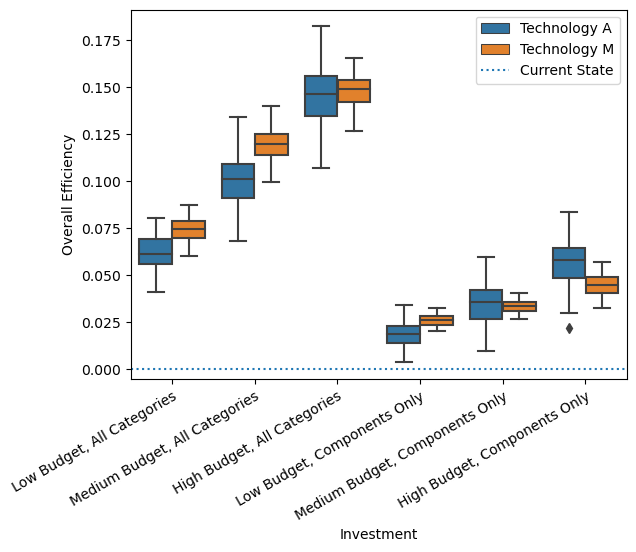

In [13]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    hue="Technology",
    data=investment_results.metrics.xs(
        "Delta Overall Efficiency",
        level="Index"
    ).groupby(
        ["Technology","Investment", "Sample"]
    ).sum(
        numeric_only=True
    ).reset_index()[["Technology","Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Medium Budget, All Categories"      ,
        "High Budget, All Categories",
        "Low Budget, Components Only"  ,
        "Medium Budget, Components Only"    ,
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Overall Efficiency")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

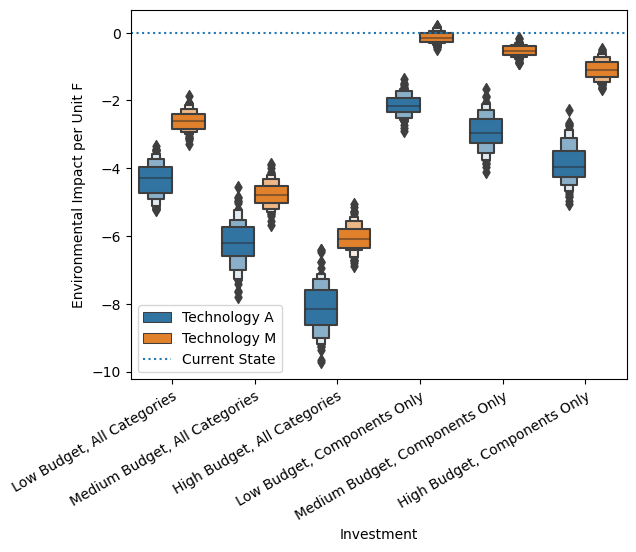

In [14]:
g = sb.boxenplot(
    x="Investment",
    y="Value",
    hue="Technology",
    data=investment_results.metrics.xs(
        "Delta Environment",
        level="Index"
    ).groupby(
        ["Technology","Investment", "Sample"]
    ).sum(
        numeric_only=True
    ).reset_index()[["Technology","Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Medium Budget, All Categories"      ,
        "High Budget, All Categories",
        "Low Budget, Components Only"  ,
        "Medium Budget, Components Only"    ,
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Environmental Impact per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

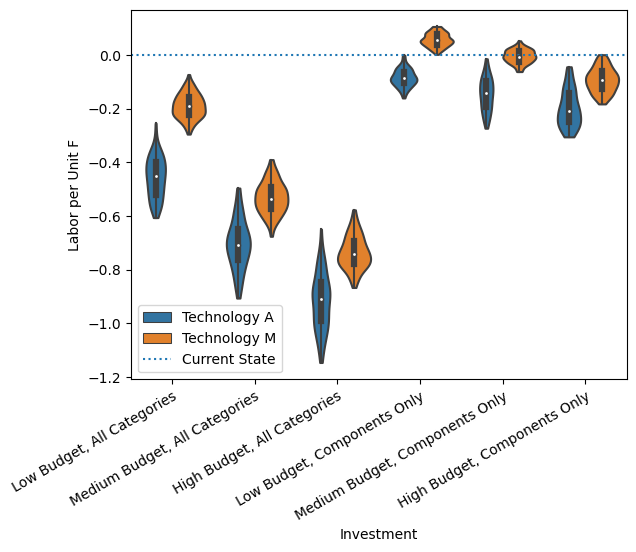

In [15]:
g = sb.violinplot(
    x="Investment",
    y="Value",
    hue="Technology",
    cut=0,
    data=investment_results.metrics.xs(
        "Delta Labor",
        level="Index"
    ).groupby(
        ["Technology","Investment", "Sample"]
    ).sum(
        numeric_only=True
    ).reset_index()[["Technology","Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Medium Budget, All Categories"      ,
        "High Budget, All Categories",
        "Low Budget, Components Only"  ,
        "Medium Budget, Components Only"    ,
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Labor per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

C:\Users\rhanes\AppData\Local\Temp\1\ipykernel_20028\2925798389.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')


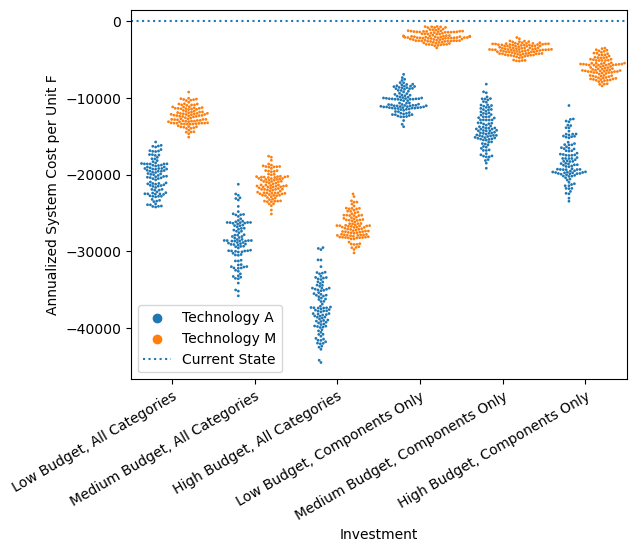

In [16]:
g = sb.swarmplot(
    x="Investment",
    y="Value",
    hue="Technology",
    size=2,
    dodge=True,
    data=investment_results.metrics.xs(
        "Delta System Cost",
        level="Index"
    ).groupby(
        ["Technology","Investment", "Sample"]
    ).sum(
        numeric_only=True
    ).reset_index()[["Technology","Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Medium Budget, All Categories"      ,
        "High Budget, All Categories",
        "Low Budget, Components Only"  ,
        "Medium Budget, Components Only"    ,
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Annualized System Cost per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')
g.axhline(y=0, linestyle=":", label='Current State')
g.legend()

## Multi-objective decision analysis.

### Compute costs and metrics for tranches.

Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [17]:
tranche_results = investments.evaluate_tranches(designs, sample_count=100)

Evaluating Technology A
Evaluating Technology M


Display the cost of each tranche.

In [18]:
tranche_results.amounts

Amount
Category                 Tranche                               
Research on Component B0 Component B0 High Funding    3500000.0
                         Component B0 Low Funding     1500000.0
                         Component B0 Medium Funding  1800000.0
                         Component B0 No Funding            0.0
Research on Component B1 Component B1 High Funding    3000000.0
                         Component B1 Low Funding     1250000.0
                         Component B1 Medium Funding  1000000.0
                         Component B1 No Funding            0.0
Research on Component B2 Component B2 High Funding    2500000.0
                         Component B2 Low Funding     1000000.0
                         Component B2 Medium Funding  1200000.0
                         Component B2 No Funding            0.0
Research on Component C  Component C High Funding     3000000.0
                         Component C Low Funding      1000000.0
                         Component C Medium Funding   2000000.0
                         Component C No Funding             0.0
Research on Component N  Component N High Funding     3500000.0
                         Component N Low Funding      1750000.0
                         Component N Medium Funding   2500000.0
                         Component N No Funding             0.0
Research on Efficiency   Efficiency High Funding      2500000.0
                         Efficiency Low Funding       1500000.0
                         Efficiency Medium Funding    2000000.0
                         Efficiency No Funding              0.0
Research on Peripherals  Peripherals High Funding     2250000.0
                         Peripherals Low Funding      1250000.0
                         Peripherals Medium Funding   1750000.0
                         Peripherals No Funding             0.0

Display the metrics for each tranche.

In [19]:
tranche_results.summary

Value  \
Category                 Technology   Tranche                   Sample Index                                 
Research on Component B0 Technology A Component B0 High Funding 1      Delta Environment          0.004191   
                                                                       Delta Labor                0.021209   
                                                                       Delta Overall Efficiency  -0.003374   
                                                                       Delta System Cost        -86.537428   
                                                                2      Delta Environment          0.004191   
...                                                                                                    ...   
Research on Peripherals  Technology M Peripherals No Funding    99     Delta System Cost        -54.477587   
                                                                100    Delta Environment          0.036400   
                                                                       Delta Labor                0.016639   
                                                                       Delta Overall Efficiency   0.002722   
                                                                       Delta System Cost        -54.477587   

                                                                                                                        Units  
Category                 Technology   Tranche                   Sample Index                                                   
Research on Component B0 Technology A Component B0 High Funding 1      Delta Environment                    delta unit/system  
                                                                       Delta Labor                           delta USD/system  
                                                                       Delta Overall Efficiency                      unitless  
                                                                       Delta System Cost         delta USD/system, annualized  
                                                                2      Delta Environment                    delta unit/system  
...                                                                                                                       ...  
Research on Peripherals  Technology M Peripherals No Funding    99     Delta System Cost         delta USD/system, annualized  
                                                                100    Delta Environment                    delta unit/system  
                                                                       Delta Labor                           delta USD/system  
                                                                       Delta Overall Efficiency                      unitless  
                                                                       Delta System Cost         delta USD/system, annualized  

[22400 rows x 2 columns]

## Optimization: Setup

Fit a response surface to the results.

The response surface interpolates between the discrete set of cases provided in the expert elicitation. This allows us to study funding levels intermediate between those scenarios.

In [20]:
evaluator = ty.Evaluator(tranche_results)

Here are the categories of investment and the maximum amount that could be invested in each:

In [21]:
evaluator.max_amount

,Amount
Category,
Research on Component B0,3500000.0
Research on Component B1,3000000.0
Research on Component B2,2500000.0
Research on Component C,3000000.0
Research on Component N,3500000.0
Research on Efficiency,2500000.0
Research on Peripherals,2250000.0


Create an `optimizer` object to define and solve single- and multi-objective optimization problems.

In [22]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

## Optimization: Single Objective

Given a budget of \\$5M USD, what's the highest possible increase in overall efficiency?

In [23]:
efficiency_5M = optimizer.opt_slsqp(
    'Delta Overall Efficiency', # Name of the metric to be optimized
    sense = 'max'             , # Should the metric be minimized or maximized?
    total_amount = 5e6        , # What's the budget (USD)?
    statistic    = np.mean    , # What statistic should be used in the optimization?
)
print(efficiency_5M.exit_message)
if efficiency_5M.exit_code == 0:
    print('\nInvestment by Category:')
    print(np.round(efficiency_5M.amounts))
    print('\nImpact on Metrics:')
    print(efficiency_5M.metrics.apply(np.round, decimals=2))

Optimization terminated successfully

Investment by Category:
Category
Research on Component B0          0.0
Research on Component B1    2500000.0
Research on Component B2          0.0
Research on Component C           0.0
Research on Component N           0.0
Research on Efficiency      2500000.0
Research on Peripherals           0.0
Name: Amount, dtype: float64

Impact on Metrics:
Index
Delta Environment              -4.49
Delta Labor                    -0.47
Delta Overall Efficiency        0.10
Delta System Cost          -20774.40
Name: Value, dtype: float64


Looking under Impact on Metrics, we see that the highest possible increase in overall efficiency with a budget of \\$5M is 0.10. To achieve this increase, funding is allocated as shown under Investment by Category: Component B1 and Efficiency are funded equally. No funding is allocated to any other category.

Can we achieve a higher increase in overall efficiency if we increase the budget from \\$5M to \\$8M?

In [24]:
efficiency_8M = optimizer.opt_slsqp(
    'Delta Overall Efficiency', # Name of the metric to be optimized
    sense = 'max'             , # Should the metric be minimized or maximized?
    total_amount = 8e6        , # What's the budget (USD)?
    statistic    = np.mean    , # What statistic should be used in the optimization?
    maxiter=100,
)
print(efficiency_8M.exit_message)
if efficiency_8M.exit_code == 0:
    print('\nInvestment by Category:')
    print(np.round(efficiency_8M.amounts))
    print('\nImpact on Metrics:')
    print(efficiency_8M.metrics.apply(np.round, decimals=2))

Optimization terminated successfully

Investment by Category:
Category
Research on Component B0          0.0
Research on Component B1    2514806.0
Research on Component B2    1200000.0
Research on Component C           0.0
Research on Component N       35194.0
Research on Efficiency      2500000.0
Research on Peripherals     1750000.0
Name: Amount, dtype: float64

Impact on Metrics:
Index
Delta Environment              -5.95
Delta Labor                    -0.67
Delta Overall Efficiency        0.12
Delta System Cost          -27145.43
Name: Value, dtype: float64


With an additional \\$3M in the budget, the increase in overall efficiency is 0.13 (compare to 0.10 with the lower budget). The funding allocation has also changed: Component B1 now has the highest funding allocation, followed by Efficiency, Peripherals, and finally Component B. No other category receives funding.

Note that in the code block above, an additional optimization parameter was added: `maxiter` was set to 100. This parameter sets the number of iterations that the algorithm is allowed to perform before terminating, in the case that an optimum is not found. By default, `maxiter` is 50, but this problem cannot solve within 50 iterations. By allowing for 100 iterations, the algorithm was able to find an optimum.

Returning to the \\$5M budget, what's the largest possible decrease in environmental impacts?

Note we are now interested in minimizing the metric being optimized. In the previous two problems, we were interested in increasing efficiency and so we maximized the metric.

In [25]:
env_5M = optimizer.opt_slsqp(
    'Delta Environment', # Name of the metric to be optimized
    sense = 'min'      , # Minimize the environmental impact metric
    total_amount = 5e6 , # Set the budget at 5 million USD
    statistic = np.mean, # Use the neutral mean statistic
)
print(env_5M.exit_message)
if env_5M.exit_code == 0:
    print('\nInvestment by Category:')
    print(np.round(env_5M.amounts))
    print('\nImpact on Metrics:')
    print(env_5M.metrics.apply(np.round, decimals=2))

Optimization terminated successfully

Investment by Category:
Category
Research on Component B0          0.0
Research on Component B1    2500000.0
Research on Component B2          0.0
Research on Component C           0.0
Research on Component N           0.0
Research on Efficiency      2500000.0
Research on Peripherals           0.0
Name: Amount, dtype: float64

Impact on Metrics:
Index
Delta Environment              -4.49
Delta Labor                    -0.47
Delta Overall Efficiency        0.10
Delta System Cost          -20774.40
Name: Value, dtype: float64


This is the same optimum that was found when efficiency was maximized, indicating that this funding allocation represents the best possible performance in both metrics.

In [26]:
lab_5M = optimizer.opt_slsqp(
    'Delta Labor', # Name of the metric to be optimized
    sense = 'min'      , # Minimize the environmental impact metric
    total_amount = 5e6 , # Set the budget at 5 million USD
    statistic = np.mean, # Use the neutral mean statistic
)
print(lab_5M.exit_message)
if lab_5M.exit_code == 0:
    print('\nInvestment by Category:')
    print(np.round(lab_5M.amounts))
    print('\nImpact on Metrics:')
    print(lab_5M.metrics.apply(np.round, decimals=2))

Optimization terminated successfully

Investment by Category:
Category
Research on Component B0          0.0
Research on Component B1     522581.0
Research on Component B2    1200002.0
Research on Component C           0.0
Research on Component N      777417.0
Research on Efficiency      2500000.0
Research on Peripherals           0.0
Name: Amount, dtype: float64

Impact on Metrics:
Index
Delta Environment              -4.21
Delta Labor                    -0.54
Delta Overall Efficiency        0.09
Delta System Cost          -19478.27
Name: Value, dtype: float64


In [27]:
cos_5M = optimizer.opt_slsqp(
    'Delta System Cost', # Name of the metric to be optimized
    sense = 'min'      , # Minimize the environmental impact metric
    total_amount = 4.85e6 , # Set the budget at 5 million USD
    statistic = np.mean, # Use the neutral mean statistic
)
print(cos_5M.exit_message)
if cos_5M.exit_code == 0:
    print('\nInvestment by Category:')
    print(np.round(cos_5M.amounts))
    print('\nImpact on Metrics:')
    print(cos_5M.metrics.apply(np.round, decimals=2))

Optimization terminated successfully

Investment by Category:
Category
Research on Component B0          0.0
Research on Component B1    2350002.0
Research on Component B2          0.0
Research on Component C           0.0
Research on Component N           0.0
Research on Efficiency      2499994.0
Research on Peripherals           0.0
Name: Amount, dtype: float64

Impact on Metrics:
Index
Delta Environment              -4.44
Delta Labor                    -0.47
Delta Overall Efficiency        0.10
Delta System Cost          -20544.54
Name: Value, dtype: float64


## Optimization: Multi-Objective via $\epsilon$ constraint method

Virtually all decision contexts analyzed with Tyche will involve multiple, probably competing or conflicting, objectives (metrics). The $\epsilon$ constraint method is one way to include multiple metrics in a single objective problem, instead of the single-objective problems demonstrated above. In the $\epsilon$ constraint method, a single metric is chosen to be maximized or minimized subject to constraints on one or more additional metrics that represent desired progress.

For instance, suppose we want to find out how much we can increase efficiency with a \\$5M budget, but we simultaneously want to reduce the environmental impact by at least 5 units per unit of output F. Using the $\epsilon$ constraint method built into Tyche, this problem is set up and solved in the code block below.

In [28]:
lab_env_5M = optimizer.opt_slsqp(
    metric = 'Delta Labor',
    sense = 'min', 
    total_amount = 5e6,
    eps_metric = {'Delta Environment': 
                  {'limit': -4.45,
                   'sense': 'upper'}},
)

print(lab_env_5M.exit_message)
if lab_env_5M.exit_code == 0:
    print('\nInvestment by Category:')
    print(np.round(lab_env_5M.amounts))
    print('\nImpact on Metrics:')
    print(lab_env_5M.metrics.apply(np.round, decimals=2))

Optimization terminated successfully

Investment by Category:
Category
Research on Component B0          0.0
Research on Component B1    2254813.0
Research on Component B2     245187.0
Research on Component C           0.0
Research on Component N           0.0
Research on Efficiency      2500000.0
Research on Peripherals           0.0
Name: Amount, dtype: float64

Impact on Metrics:
Index
Delta Environment              -4.45
Delta Labor                    -0.48
Delta Overall Efficiency        0.10
Delta System Cost          -20597.42
Name: Value, dtype: float64
